In [1000]:
import pandas as pd
import glob
import geopy.geocoders
import pygeohash as pgh
import pygeodesy
from geolib import geohash
import numpy as np
from numpy.core.defchararray import find, lower
from scipy import stats
import random
import time

In [2]:
path = '/Users/alefe/Workspace/TCC/DataPrepared'
branchAddress = pd.read_csv(path + '/branchAddress.csv' ,sep=';', index_col=None, header=0)
patientAddress = pd.read_csv(path + '/patientAddress.csv' ,sep=';', index_col=None, header=0)
professionalAddress = pd.read_csv(path + '/professionalAddress.csv' ,sep=';', index_col=None, header=0)
visitationByProfessional = pd.read_csv(path + '/visitationGroupBy.csv' ,sep=';', index_col=None, header=0)
visitationByProfession = pd.read_csv(path + '/visitationGroupByGlobal.csv' ,sep=';', index_col=None, header=0)


In [3]:
branchAddress = branchAddress.loc[branchAddress['geohash'].apply(lambda x: x[0:4])  == '7vmd']

In [4]:
branchAddress.head(100)

,id,branchId,geohash
0,0,branch-18,7vmdf3kpxpyu


In [5]:
patientAddress = patientAddress.loc[patientAddress['geohash'].apply(lambda x: x[0:4])  == '7vmd']

In [6]:
patientAddress.head()

,id,patientId,geohash
32,32,patient-2476,7vmdf9mq4vmy
39,39,patient-2483,7vmdt5fuqd1m
42,42,patient-2486,7vmduqn74y4z
53,53,patient-2497,7vmdu3zjyusy
54,54,patient-2498,7vmdtjume49w


In [7]:
professionalAddress = professionalAddress.loc[professionalAddress['geohash'].apply(lambda x: x[0:4])  == '7vmd']

In [8]:
professionalAddress.head()

,id,professionalId,profession,geohash
1,1,professional-224,ENFERMEIRO (A),7vmdt5e3w4vd
2,2,professional-225,ENFERMEIRO (A),7vmdt3j32tsm
4,4,professional-227,ENFERMEIRO (A),7vmdmnzzctd9
5,5,professional-228,ENFERMEIRO (A),7vmdt12vgfd8
7,7,professional-230,ENFERMEIRO (A),7vmdmjc1h4kq


In [9]:
visitationByProfessional.head()

,id,profession,max_duration,min_duration,mean_duration,median_duration,mode_duration
0,professional-232,ENFERMEIRO (A),4319.0,622.0,1205.875000,1036.0,622.0
1,professional-235,ENFERMEIRO (A),1200.0,1200.0,1200.000000,1200.0,1200.0
2,professional-240,ENFERMEIRO (A),3433.0,787.0,2120.250000,2548.0,787.0
3,professional-241,ENFERMEIRO (A),8257.0,660.0,1337.716216,1128.5,966.0
4,professional-267,ENFERMEIRO (A),5415.0,606.0,2149.908046,1902.0,1403.0


In [10]:
visitationByProfession.head()

,profession,max_duration,min_duration,mean_duration,median_duration,mode_duration
0,ENFERMEIRO (A),8930.0,601.0,2484.334622,2160.0,1964.0
1,FISIOTERAPEUTA,1029.0,1029.0,1029.000000,1029.0,1029.0
2,MEDICO (A),4706.0,603.0,1334.555556,661.0,603.0


In [11]:
def sortIndividual(individual):
    while (individual[len(individual) - 1].find("branch")!=0):
        individual = np.roll(individual, -1)
    
    return individual

In [12]:
def getRoutes(individual):
    routeList = []
    individual = sortIndividual(individual)
    for i in range(len(individual)):
        if(i == 0 or individual[i - 1].find("branch")==0):
            route = []
        if(individual[i].find("patient")==0):
            route.append(individual[i])
        if(individual[i].find("branch")==0): 
            route.append(individual[i])
            routeList.append(route)
    return routeList;

In [13]:
## Algoritmo Genético
# Geração de individuos

# o cromossomo é formado por X Profissionais Y pacientes e uma Filial F
# o numero de Pacientes Y não pode ser inferior que o numero de Profissionais X
# Todos os profissionais devem pertencer a mesma profissão
# Uma Filial não pode ser visinha de outra.
# Um profissional não pode ser visinho de outro.

# Exemplo de Cromossomo:
# y1 | y2 | b1 | y3 | y4 | y5 | b2 | 

# Tamanho do Cromossomo é dado por: X*F + Y  

def generatePopulation(size, professionalList, pacientList, branch):
    if(len(professionalList) > len(pacientList)): return
    population = []
    branchList = []
    
    for i in range(len(professionalList)):
        branchList.append(branch[0] +'.'+ str(i))
    for i in range(size):
        individual = pacientList
        branchIterate = branchList
        count = len(branchIterate)
        while(count != 0):
            if (len(branchIterate) == len(professionalList)):
                random.shuffle(individual)
                last, branchIterate = branchIterate[-1], branchIterate[:-1]
                individual = np.append(individual, last)
                count -= 1
            else:
                index = np.where(individual == random.choice(individual))[0][0]
                if(index !=0 and individual[index].find("patient")==0 and individual[index - 1].find("patient")==0):
                    last, branchIterate = branchIterate[-1], branchIterate[:-1]
                    individual = np.insert(individual,index, last)
                    count -= 1
        population.append(individual)
    return np.array(population)

In [14]:
def calcDistance(route, professional):
    distance = 0
    durationVisit = 0
    durationProvidingAccount = 1800
    if (not(visitationByProfessional.loc[(visitationByProfessional.id == professional)].empty)):
        duration = visitationByProfessional.loc[(visitationByProfessional.id == professional)]['mean_duration'].values[0]
    else:
        profession = professionalList.loc[(professionalList.professionalId == professional)]['profession'].values[0]
        duration = visitationByProfession.loc[(visitationByProfession.profession == profession)]['mean_duration'].values[0]
        
    if(len(route) == 1):
        return 0;
        
    for i in range(len(route)):
        if(i==0):
            origin = professionalList.loc[(professionalList.professionalId == professional)]['geohash'].values[0]
            destine = patientList.loc[(patientList.patientId == route[i])]['geohash'].values[0]
        else:
            origin = patientList.loc[(patientList.patientId == route[i - 1])]['geohash'].values[0]
            if route[i].find("patient")==0:
                destine = patientList.loc[(patientList.patientId == route[i])]['geohash'].values[0]
            else:
                nameBranch = route[i].split(sep='.',maxsplit=2)[0]
                destine = branch.loc[(branch.branchId == nameBranch)]['geohash'].values[0]
        distance += pygeodesy.geohash.distance_(destine, origin)
        
    return (((distance/1000)/21)*3600 + durationVisit*(len(route) - 1) + durationProvidingAccount);

In [15]:
def sortPopulation(population, professionalIdList):
    return sorted(population, key=lambda individual:applyFunction(individual, professionalIdList))

In [16]:
def choiceByRoulette(sortedPopulation, professionalIdList, fitnessSum):
    offset = 0
    normalizedFitnessSum = fitnessSum

    lowestFitness = applyFunction(sortedPopulation[0], professionalIdList)
    if lowestFitness < 0:
        offset = - lowestFitness
        normalizedFitnessSum += offset * len(sortedPopulation)

    draw = random.uniform(0, 1)

    accumulated = 0
    for individual in sortedPopulation:
        fitness = applyFunction(individual, professionalIdList) + offset
        probability = fitness/normalizedFitnessSum
        accumulated += probability

        if draw <= accumulated:
            return individual

In [17]:
def tournament_selection(population, professionalIdList):
        tournamentList = population
        newPopulation = []
        for individual in range(len(population) // 2):
            roundList = []
            candidate1 = random.choice(tournamentList)
            roundList.append(candidate1)
            np.delete(tournamentList, np.where(tournamentList == candidate1)[0][0], axis=0)
            candidate2 = random.choice(tournamentList)
            roundList.append(candidate2)
            np.delete(tournamentList, np.where(tournamentList == candidate2)[0][0], axis=0)
           
            #sort solutions by fitness
            roundList.sort(key=lambda x: applyFunction(x, professionalIdList), reverse=False)
            newPopulation.append(roundList[0])
            
        return np.array(newPopulation)

In [18]:
def applyFunction(individual, professionalIdList, best = False):
    routeList = getRoutes(individual)
    fitness = 0 
    totalTime = 0
    limit = 25200
    for i in range(len(routeList)):
        totalTime = calcDistance(routeList[i], professionalIdList[i]);
        if (totalTime > limit):
            totalTime = totalTime * limit 
        if best == True :
            if (totalTime > limit or totalTime == 0):
                print('Route: ', i, " Time exceded limit: ", totalTime , " seconds")
            print('Route: ', i, " Time estimated: ", totalTime , " seconds")
        fitness += totalTime
    
    return fitness

In [1006]:
def makeNextGeneration(previousPopulation, professionalIdList, alpha):
    populationSelected = selection(previousPopulation,professionalIdList, 'tournament_selection')
    nextGeneration = []
    
    for i in range(len(populationSelected) // 2):
        parentList = random.choices(populationSelected, k=2)
        individualFather = parentList[0]
        individualMother = parentList[1]
        individualChildA, individualChildB  = crossover(individualFather, individualMother, 'order_based_crossover')
        nextGeneration.append(individualChildA)
        nextGeneration.append(individualChildB)
    nextGeneration = np.concatenate((populationSelected, np.array(nextGeneration)), axis=0)
    
    for i in range(len(nextGeneration)):
        nextGeneration[i] = mutation(nextGeneration[i], alpha, 'ism')
        
    return nextGeneration

In [20]:
# Cruzamento de mapeamento parcial (PMX)

def pmx(a,b, start, stop):
    child = [None]*len(a)
    # Copy a slice from first parent:
    child[start:stop] = a[start:stop]
    # Map the same slice in parent b to child using indices from parent a:
    for ind,x in enumerate(b[start:stop]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = np.where(b == a[ind])[0][0]
            child[ind] = x
    # Copy over the rest from parent b
    for ind,x in enumerate(child):
        if x == None:
            child[ind] = b[ind]
    return np.array(child)

def pmx_pair(a,b):
    half = len(a) // 2
    start = random.randint(0, len(a)-half)
    stop = start + half
    return pmx(a,b,start,stop) , pmx(b,a,start,stop)

In [21]:
def edge_recombination(parentA, parentB):
    lengthChromosome = len(parentA)
    neighborA = []
    neighborB = []
    child = []
    for index in range(len(parentA)):
        leftNeighbor =  parentA[-1] if index - 1 < 0 else parentA[index - 1]
        rightNeighbor = parentA[0] if index + 1 >= len(parentA) else parentA[index + 1]
        neighborA.append({ parentA[index]: [leftNeighbor, rightNeighbor]}) 
    neighborA = np.array(neighborA)
    for index in range(len(parentB)):
        leftNeighbor =  parentB[-1] if index - 1 < 0 else parentB[index - 1]
        rightNeighbor = parentB[0] if index + 1 >= len(parentB) else parentB[index + 1]
        neighborB.append({ parentB[index]: [leftNeighbor, rightNeighbor]}) 
    neighborList = []
    neighborB = np.array(neighborB)
    
    for index in range(len(neighborA)):
        keyA = [*neighborA[index]][0]
        indexB = np.where(np.array(parentB) == keyA)[0][0]
        keyB = [*neighborB[indexB]][0]
        neighborList.append({ keyA : unionNeighbor(neighborA[index][keyA], neighborB[indexB][keyB])})

     # seleciona um index aleatorio
    index = random.randint(0, len(neighborList) - 1)
    selected = [*neighborList[index]][0]
    selectedNeighbor = [*neighborList[index][selected]]
    while(len(child) < lengthChromosome):
        # Pega a chave do index e adiciona no filho
       
        child.append(selected)
        
        # Remove o item escolhido aleatoriamento do Lista de visinhos
        neighborList = np.delete(neighborList,index, axis=0)
      
        # Remove o item adicionado no filho da Lista de visinhos de grupos de visinhos
        neighborList, lengthList = remove_all(selected, neighborList)
        if(len(neighborList) > 0):
            if (len(selectedNeighbor) == 0):
                index = random.randint(0, len(neighborList) - 1)
                selected = [*neighborList[index]][0]
                selectedNeighbor = [*neighborList[index][selected]]
            else:
                lengthList = sorted(lengthList, key=lambda x: x[1])
                tieList = []
                for i in range(len(lengthList)):
                    if(i == 0):
                        tieList.append(lengthList[i][0])
                    elif (lengthList[i][1] == lengthList[i - 1][1]):
                        tieList.append(lengthList[i][0])
                selected = random.choice(tieList)
                selectedNeighbor = next(x for x in neighborList if [*x][0] == selected )[selected]
                index = np.where(np.array(neighborList) == {selected:selectedNeighbor})[0][0]
    
    return np.array(child)

def unionNeighbor(neighborA, neighborB):
    return list(set(neighborA) | set(neighborB))

def remove_all(item, neighbor):
    lengthList = []
    for index in range(len(neighbor)):
        key = [*neighbor[index]][0]
        list = [neighbor[index][key]][0]
        if (item in list):
            list.remove(item) 
        lengthList.append((key, len(list)))
    return neighbor, lengthList

def edge_recombination_pair(a,b):
    return edge_recombination(a,b) , edge_recombination(b,a)

In [998]:
# Order Based Crossover (OX2)
def order_based_crossover(parentA, parentB):
    child = []
    half = len(parentA) // 2
    slice1 = random.randint(0, half)
    slice2 = random.randint(half, len(parentA) - 1)
    partMiddle = parentA[slice1:slice2]
    lista = [None] * (len(parentB))
    lista = np.array(lista)
    for i, value in enumerate(partMiddle):
        order = np.where(parentB == value)[0][0]
        lista[order] = value
    lista = lista[lista != np.array(None)]
    child = np.concatenate((parentA[0:slice1], lista, parentA[slice2:len(parentA)]), axis=0) 
    return np.array(child)

def order_based_crossover_pair(a, b):
    return order_based_crossover(a, b),order_based_crossover(b, a)

In [22]:
# O operador de mutação por troca (exchange mutation – EM)

def em(individual, alpha):
    u = random.uniform(0, 1)
    if (u <= alpha):
        pointList = random.choices(individual, k=2)
        point1 = pointList[0]
        indexPoint1 = np.where(individual == point1)
        point2 = pointList[1]
        indexPoint2 = np.where(individual == point2)
        individual[indexPoint1] = point2
        individual[indexPoint2] = point1 
    return individual

In [451]:
# Mutação por inversão simples (SIM)
def sim(individual, alpha):
    u = random.uniform(0, 1)
    if (u <= alpha):
        half = len(individual) // 2
        slice1 = random.randint(0, half)
        slice2 = random.randint(half, len(individual) - 1)
        middlePart = individual[slice1:slice2]
        firstPart = individual[0:slice1]
        lastPart = individual[slice2:len(individual)]
        revertMiddle = middlePart[::-1]
        individual = np.concatenate((firstPart, revertMiddle ,lastPart), axis=0)
    return individual

In [726]:
def ism(individual, alpha):
    u = random.uniform(0, 1)
    if (u <= alpha):
        selected = random.randint(0, len(individual) - 1)
        element = individual[selected]
        individual = np.delete(individual, selected)
        newPosition = random.randint(0, len(individual))
        individual = np.concatenate((individual[:newPosition] , [element] ,individual[newPosition:]), axis=0)

    return individual

In [994]:
def crossover(parent1,parent2,type):
    if(type== 'pmx'):
        return pmx_pair(parent1,parent2)
    if(type== 'edge_recombination'):
        return edge_recombination_pair(parent1,parent2)
    if(type== 'order_based_crossover'):
        return order_based_crossover_pair(parent1, parent2)

In [24]:
def selection(population,professionalIdList,  type):
    if(type=='tournament_selection'):
        return tournament_selection(population, professionalIdList)

In [725]:
def mutation(individual, alpha, type):
    if(type == 'em'):
        return em(individual, alpha)
    if(type == 'sim'):
        return sim(individual, alpha)
    if(type == 'ism'):
        return ism(individual, alpha)

In [1007]:
inicio = time.time()
generations = 500
populationSize = 100
alpha = 0.2
random.seed(1)

professional = professionalAddress.loc[professionalAddress['profession']== 'MEDICO (A)']
professionalList = professional.sample(n= 10, random_state=1)
professionalIdList = professionalList['professionalId'].iloc[0:].values

patientList = patientAddress.sample(n= 50, random_state=1)
patientIdList = patientList['patientId'].iloc[0:].values

branch = branchAddress.sample(random_state=1)
branchId = branch['branchId'].iloc[0:].values

population = generatePopulation(populationSize, professionalIdList, patientIdList, branchId)

i = 1
while True:
    print("Generation: " + str(i))
    if i == generations:
        break
    i += 1
    population = makeNextGeneration(population, professionalIdList, alpha)
finalPopulation = sortPopulation(population, professionalIdList)
bestIndividual = sortPopulation(population, professionalIdList)[0]
poorIndividual = sortPopulation(population, professionalIdList)[-1]
print("Poor Individual: ")
print(poorIndividual, applyFunction(poorIndividual, professionalIdList, True))
print("Best Individual: ")
print(bestIndividual, applyFunction(bestIndividual, professionalIdList, True))
fim = time.time()
print(fim - inicio)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

In [ ]:
PMX and EM
Best : 75466.93954285714 second
Time execute: 2823.749059677124 second
['patient-2763' 'patient-3275' 'branch-18.3' 'branch-18.6' 'patient-6167'
 'patient-5533' 'patient-2911' 'patient-3739' 'patient-6159'
 'patient-3838' 'patient-2627' 'patient-3425' 'patient-6155' 'branch-18.2'
 'branch-18.4' 'patient-3879' 'patient-3945' 'patient-3681' 'patient-6235'
 'patient-3924' 'patient-2929' 'patient-2844' 'patient-4078'
 'patient-6476' 'patient-3280' 'patient-2924' 'branch-18.8' 'patient-3802'
 'patient-5222' 'patient-3299' 'patient-5651' 'patient-5316'
 'patient-5284' 'patient-3274' 'patient-6100' 'patient-5624'
 'patient-2765' 'patient-3673' 'patient-3422' 'branch-18.1' 'patient-3337'
 'patient-2834' 'patient-4318' 'patient-3784' 'patient-5878' 'branch-18.0'
 'branch-18.9' 'branch-18.7' 'patient-5638' 'patient-2890' 'patient-5653'
 'patient-3797' 'patient-2497' 'patient-5684' 'patient-5339'
 'patient-3740' 'branch-18.5' 'patient-2500' 'patient-3834' 'patient-3947']


In [ ]:
edge_recombination and SIM
Best Fitness: 138529.10914285714
Time execute: 3239.6864058971405
['patient-2834' 'branch-18.1' 'patient-3425' 'patient-4318' 'patient-2929'
 'patient-6155' 'patient-2500' 'patient-2890' 'patient-3275'
 'patient-3947' 'patient-2763' 'patient-5638' 'branch-18.3' 'branch-18.9'
 'patient-3274' 'patient-3681' 'patient-5533' 'patient-5684'
 'patient-5653' 'patient-2765' 'patient-5339' 'patient-2627'
 'patient-3797' 'branch-18.8' 'branch-18.0' 'patient-3945' 'patient-3802'
 'patient-3879' 'patient-5624' 'patient-2911' 'branch-18.6' 'patient-3280'
 'patient-3673' 'patient-3422' 'branch-18.5' 'patient-3924' 'patient-3337'
 'patient-3299' 'patient-5878' 'patient-6235' 'patient-3834' 'branch-18.7'
 'patient-6476' 'patient-3740' 'patient-4078' 'patient-5316' 'branch-18.4'
 'patient-6100' 'patient-6167' 'patient-3739' 'patient-2844'
 'patient-2924' 'patient-3838' 'patient-5284' 'branch-18.2' 'patient-3784'
 'patient-6159' 'patient-5651' 'patient-5222' 'patient-2497']


In [ ]:
order_based_crossover and ISM
Best Fitness: 66915.19285714286
Time execute: 2863.4145805835724
['branch-18.2' 'patient-3681' 'patient-6167' 'patient-5533' 'patient-3784'
 'patient-5878' 'patient-6476' 'patient-2497' 'patient-5684'
 'patient-5339' 'patient-4078' 'patient-3947' 'patient-5316'
 'patient-6155' 'patient-3425' 'branch-18.5' 'branch-18.4' 'patient-6100'
 'patient-3274' 'patient-5284' 'patient-3275' 'patient-5651'
 'patient-2763' 'patient-2500' 'patient-3802' 'patient-3838'
 'patient-6159' 'patient-3740' 'branch-18.1' 'branch-18.7' 'patient-6235'
 'patient-5222' 'patient-3299' 'patient-2844' 'patient-2929'
 'patient-5638' 'patient-2834' 'patient-3797' 'patient-3337'
 'patient-2890' 'patient-4318' 'patient-2627' 'patient-5653'
 'patient-3924' 'patient-2911' 'patient-3739' 'patient-3834' 'branch-18.8'
 'branch-18.6' 'branch-18.3' 'branch-18.0' 'patient-3879' 'patient-3945'
 'patient-3673' 'patient-5624' 'patient-2765' 'patient-3280'
 'patient-2924' 'patient-3422' 'branch-18.9']


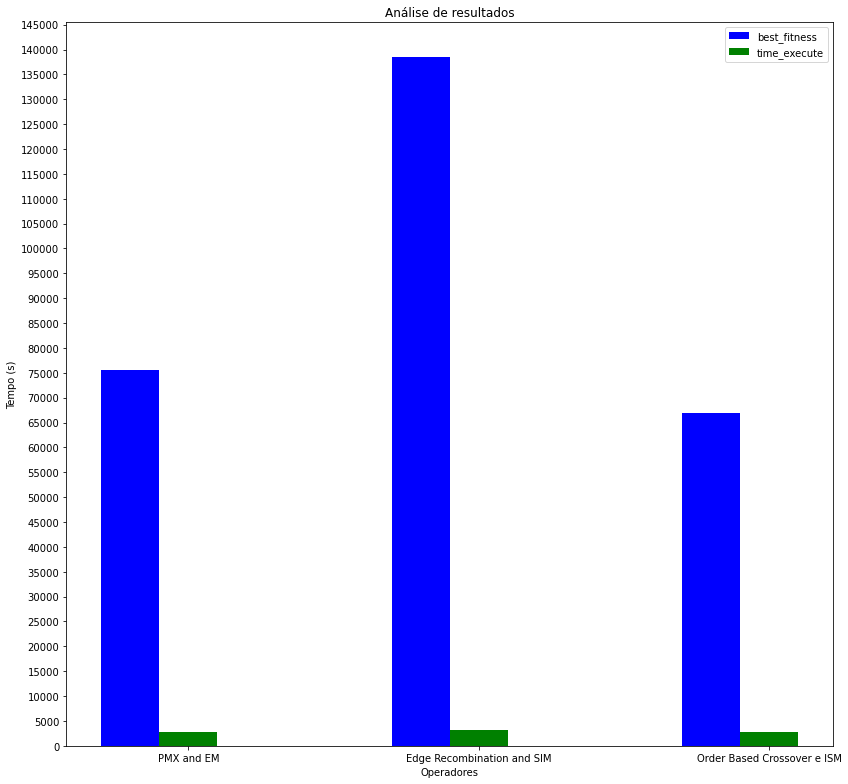

In [1059]:
def plota_bar_dupla_1():
    grupos = 3
    best_fitness = (75466.93954285714, 138529.10914285714, 66915.19285714286)
    time_execute = (2823.749059677124, 3239.6864058971405, 2863.4145805835724)
    fig, ax = plt.subplots()
    indice = np.arange(grupos)
    plt.gcf().set_size_inches(12, 11)
    plt.yticks(range(0, 180000, 5000)) 
    bar_larg = 0.2
    transp = 1
    plt.bar(indice, best_fitness, bar_larg, alpha=transp, color=azul, label='best_fitness')
    plt.bar(indice + bar_larg, time_execute, bar_larg, alpha=transp, color=verde,label='time_execute')
    plt.xlabel('Operadores')
    plt.ylabel('Tempo (s)')
    plt.title('Análise de resultados')
    plt.xticks(indice + bar_larg, ('PMX and EM', 'Edge Recombination and SIM', 'Order Based Crossover e ISM'))
    plt.legend()
    plt.tight_layout()
    plt.show()
plota_bar_dupla_1()